# Task II: Classical Graph Neural Network (GNN) 

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available [here](https://zenodo.org/records/3164691#.YigdGt9MHrB) with its corresponding description.
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures.

## Solution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tf_keras_model import get_particle_net_lite, get_particle_net
from tensorflow import keras
import logging
logging.basicConfig(level=logging.INFO,
                    format='[%(asctime)s] %(levelname)s: %(message)s')
%matplotlib inline

In [2]:
# Load the dataset
# Specify the file path
file_path = './data/QG_jets.npz'

# Check if the file exists
if not os.path.exists(file_path):
    !wget https: // zenodo.org/record/3164691/files/QG_jets.npz -P ./data

dataset = np.load('./data/QG_jets.npz', allow_pickle=True)

In [3]:
# See what keys are present in the dataset
list(dataset.keys())

['X', 'y']

In [4]:
# Extract data as per keys
x = dataset['X']
y = dataset['y']

### Data Preprocessing

As per the information of the dataset from here

X: (100000,M,4), exactly 50k quark and 50k gluon jets, randomly sorted, where M is the max multiplicity of the jets in that file (other jets have been padded with zero-particles), and the features of each particle are its pt, rapidity, azimuthal angle, and pdgid.

y: (100000,), an array of labels for the jets where gluon is 0 and quark is 1.

In [5]:
# one hot encoding labels is needed else the following error
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
y = keras.utils.to_categorical(y)
print(y.shape)

(100000, 2)


In [6]:
x, y = shuffle(x, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(
    x_test, y_test, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


In [7]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2)
print(mask_train.shape)
print(mask_train[0])

# make the array binary
mask_train = np.array(mask_train != 0, np.float32)
print(mask_train[0])

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(mask_train.shape)

(70000, 139)
[   29.20243269    27.50561143    30.26089051   220.41819997
    27.95042087    28.15969933   329.0687446     27.57628735
  -206.06003465   218.08468374    26.41602355    27.02195013
    31.79622486    26.59246689    26.88924931  -202.09822736
    26.71899363    31.23462352  -310.42681747    27.70451205
    30.7169403   -198.56554041  2233.77838649    36.42720615
    29.23621805  -187.38676832    33.46071738   268.17256202
    32.3521241  -2054.01856237   118.7019814     56.63953271
   151.53934524    57.07618763     0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.             0.

In [8]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_val = np.sum(x_val, axis=2)

# make the array binary
mask_val = np.array(mask_val != 0, np.float32)

# reshape mask for a third axis
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(mask_val.shape)

(15000, 139, 1)


In [9]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_test = np.sum(x_test, axis=2)

# make the array binary
mask_test = np.array(mask_test != 0, np.float32)

# reshape mask for a third axis
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)
print(mask_test.shape)

(15000, 139, 1)


In [10]:
train_dataset = {
    'points': x_train[:, :, 1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:, :, 1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:, :, 1:3],
    'features': x_val,
    'mask': mask_val
}

In [11]:
shapes = {
    'points': x_train[:, :, 1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'points': (139, 2), 'features': (139, 4), 'mask': (139, 1)}

In [12]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

2024-04-02 16:36:17.620043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-02 16:36:17.620245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [14]:
# Training parameters
batch_size = 1024
epochs = 100

In [15]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f' % lr)
    return lr

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2024-04-02 16:48:36,171] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 139, 1)      0           ['mask[0][0]']                   
                                                                                                  
 tf.cast (TFOpLambda)           (None, 139, 1)       0           ['tf.math.not_equal[0][0]']      
                                                                                                  
 tf.math.equal (TFOpLambda)     (None, 139, 1)       0           ['tf.cast[0][0]']                
                                                                                        

In [17]:
# Prepare model model saving directory.

save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [18]:
history = model.fit(train_dataset, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_dataset, y_val),
                    shuffle=True,
                    callbacks=callbacks)

2024-04-02 16:49:23.670600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
[2024-04-02 16:49:23,710] INFO: Learning rate: 0.001000


Epoch 1/100


2024-04-02 16:49:24.177711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


      0/Unknown - 131s 0s/sample - loss: 0.5163 - accuracy: 0.7518

2024-04-02 16:51:34.795269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.65420, saving model to model_checkpoints/particle_net_lite_model.001.h5
69/69 [==============================] - 134s 2s/sample - loss: 0.5163 - accuracy: 0.7518 - val_loss: 0.5932 - val_accuracy: 0.6542 - lr: 0.0010


[2024-04-02 16:51:37,945] INFO: Learning rate: 0.001000


Epoch 2/100
 0/69 [..............................] - ETA: 0s - loss: 0.4819 - accuracy: 0.7782
Epoch 2: val_accuracy improved from 0.65420 to 0.75473, saving model to model_checkpoints/particle_net_lite_model.002.h5
69/69 [==============================] - 121s 2s/sample - loss: 0.4819 - accuracy: 0.7782 - val_loss: 0.5239 - val_accuracy: 0.7547 - lr: 0.0010


[2024-04-02 16:53:38,724] INFO: Learning rate: 0.001000


Epoch 3/100
 0/69 [..............................] - ETA: 0s - loss: 0.4702 - accuracy: 0.7861
Epoch 3: val_accuracy improved from 0.75473 to 0.77940, saving model to model_checkpoints/particle_net_lite_model.003.h5
69/69 [==============================] - 118s 2s/sample - loss: 0.4702 - accuracy: 0.7861 - val_loss: 0.4929 - val_accuracy: 0.7794 - lr: 0.0010


[2024-04-02 16:55:36,819] INFO: Learning rate: 0.001000


Epoch 4/100
 0/69 [..............................] - ETA: 0s - loss: 0.4646 - accuracy: 0.7902
Epoch 4: val_accuracy improved from 0.77940 to 0.78580, saving model to model_checkpoints/particle_net_lite_model.004.h5
69/69 [==============================] - 118s 2s/sample - loss: 0.4646 - accuracy: 0.7902 - val_loss: 0.4644 - val_accuracy: 0.7858 - lr: 0.0010


[2024-04-02 16:57:35,003] INFO: Learning rate: 0.001000


Epoch 5/100
 0/69 [..............................] - ETA: 0s - loss: 0.4595 - accuracy: 0.7928
Epoch 5: val_accuracy improved from 0.78580 to 0.79467, saving model to model_checkpoints/particle_net_lite_model.005.h5
69/69 [==============================] - 119s 2s/sample - loss: 0.4595 - accuracy: 0.7928 - val_loss: 0.4574 - val_accuracy: 0.7947 - lr: 0.0010


[2024-04-02 16:59:33,591] INFO: Learning rate: 0.001000


Epoch 6/100
 0/69 [..............................] - ETA: 0s - loss: 0.4543 - accuracy: 0.7963
Epoch 6: val_accuracy improved from 0.79467 to 0.79480, saving model to model_checkpoints/particle_net_lite_model.006.h5
69/69 [==============================] - 119s 2s/sample - loss: 0.4543 - accuracy: 0.7963 - val_loss: 0.4554 - val_accuracy: 0.7948 - lr: 0.0010


[2024-04-02 17:01:32,406] INFO: Learning rate: 0.001000


Epoch 7/100
 0/69 [..............................] - ETA: 0s - loss: 0.4509 - accuracy: 0.7965
Epoch 7: val_accuracy improved from 0.79480 to 0.79740, saving model to model_checkpoints/particle_net_lite_model.007.h5
69/69 [==============================] - 120s 2s/sample - loss: 0.4509 - accuracy: 0.7965 - val_loss: 0.4456 - val_accuracy: 0.7974 - lr: 0.0010


[2024-04-02 17:03:32,662] INFO: Learning rate: 0.001000


Epoch 8/100
 0/69 [..............................] - ETA: 0s - loss: 0.4496 - accuracy: 0.7986
Epoch 8: val_accuracy improved from 0.79740 to 0.80227, saving model to model_checkpoints/particle_net_lite_model.008.h5
69/69 [==============================] - 115s 2s/sample - loss: 0.4496 - accuracy: 0.7986 - val_loss: 0.4384 - val_accuracy: 0.8023 - lr: 0.0010


[2024-04-02 17:05:27,812] INFO: Learning rate: 0.001000


Epoch 9/100
 0/69 [..............................] - ETA: 0s - loss: 0.4457 - accuracy: 0.8001
Epoch 9: val_accuracy did not improve from 0.80227
69/69 [==============================] - 115s 2s/sample - loss: 0.4457 - accuracy: 0.8001 - val_loss: 0.4414 - val_accuracy: 0.7997 - lr: 0.0010


[2024-04-02 17:07:23,082] INFO: Learning rate: 0.001000


Epoch 10/100
 0/69 [..............................] - ETA: 0s - loss: 0.4446 - accuracy: 0.8011
Epoch 10: val_accuracy did not improve from 0.80227
69/69 [==============================] - 115s 2s/sample - loss: 0.4446 - accuracy: 0.8011 - val_loss: 0.4489 - val_accuracy: 0.7951 - lr: 0.0010


[2024-04-02 17:09:17,833] INFO: Learning rate: 0.001000


Epoch 11/100
 0/69 [..............................] - ETA: 0s - loss: 0.4444 - accuracy: 0.8006
Epoch 11: val_accuracy improved from 0.80227 to 0.80387, saving model to model_checkpoints/particle_net_lite_model.011.h5
69/69 [==============================] - 114s 2s/sample - loss: 0.4444 - accuracy: 0.8006 - val_loss: 0.4387 - val_accuracy: 0.8039 - lr: 0.0010


[2024-04-02 17:11:12,302] INFO: Learning rate: 0.000100


Epoch 12/100
 0/69 [..............................] - ETA: 0s - loss: 0.4374 - accuracy: 0.8042
Epoch 12: val_accuracy improved from 0.80387 to 0.80500, saving model to model_checkpoints/particle_net_lite_model.012.h5
69/69 [==============================] - 115s 2s/sample - loss: 0.4374 - accuracy: 0.8042 - val_loss: 0.4321 - val_accuracy: 0.8050 - lr: 1.0000e-04


[2024-04-02 17:13:07,251] INFO: Learning rate: 0.000100


Epoch 13/100
 0/69 [..............................] - ETA: 0s - loss: 0.4363 - accuracy: 0.8054
Epoch 13: val_accuracy improved from 0.80500 to 0.80607, saving model to model_checkpoints/particle_net_lite_model.013.h5
69/69 [==============================] - 116s 2s/sample - loss: 0.4363 - accuracy: 0.8054 - val_loss: 0.4306 - val_accuracy: 0.8061 - lr: 1.0000e-04


[2024-04-02 17:15:02,998] INFO: Learning rate: 0.000100


Epoch 14/100
 0/69 [..............................] - ETA: 0s - loss: 0.4355 - accuracy: 0.8068
Epoch 14: val_accuracy did not improve from 0.80607
69/69 [==============================] - 115s 2s/sample - loss: 0.4355 - accuracy: 0.8068 - val_loss: 0.4325 - val_accuracy: 0.8058 - lr: 1.0000e-04


[2024-04-02 17:16:57,825] INFO: Learning rate: 0.000100


Epoch 15/100
 0/69 [..............................] - ETA: 0s - loss: 0.4354 - accuracy: 0.8064
Epoch 15: val_accuracy did not improve from 0.80607
69/69 [==============================] - 116s 2s/sample - loss: 0.4354 - accuracy: 0.8064 - val_loss: 0.4314 - val_accuracy: 0.8059 - lr: 1.0000e-04


[2024-04-02 17:18:53,583] INFO: Learning rate: 0.000100


Epoch 16/100
 0/69 [..............................] - ETA: 0s - loss: 0.4341 - accuracy: 0.8069
Epoch 16: val_accuracy did not improve from 0.80607
69/69 [==============================] - 116s 2s/sample - loss: 0.4341 - accuracy: 0.8069 - val_loss: 0.4344 - val_accuracy: 0.8037 - lr: 1.0000e-04


[2024-04-02 17:20:49,115] INFO: Learning rate: 0.000100


Epoch 17/100
 0/69 [..............................] - ETA: 0s - loss: 0.4342 - accuracy: 0.8076
Epoch 17: val_accuracy improved from 0.80607 to 0.80793, saving model to model_checkpoints/particle_net_lite_model.017.h5
69/69 [==============================] - 115s 2s/sample - loss: 0.4342 - accuracy: 0.8076 - val_loss: 0.4291 - val_accuracy: 0.8079 - lr: 1.0000e-04


[2024-04-02 17:22:43,760] INFO: Learning rate: 0.000100


Epoch 18/100
 0/69 [..............................] - ETA: 0s - loss: 0.4342 - accuracy: 0.8073
Epoch 18: val_accuracy did not improve from 0.80793
69/69 [==============================] - 115s 2s/sample - loss: 0.4342 - accuracy: 0.8073 - val_loss: 0.4294 - val_accuracy: 0.8059 - lr: 1.0000e-04


[2024-04-02 17:24:38,737] INFO: Learning rate: 0.000100


Epoch 19/100
 0/69 [..............................] - ETA: 0s - loss: 0.4340 - accuracy: 0.8070
Epoch 19: val_accuracy did not improve from 0.80793
69/69 [==============================] - 116s 2s/sample - loss: 0.4340 - accuracy: 0.8070 - val_loss: 0.4319 - val_accuracy: 0.8050 - lr: 1.0000e-04


[2024-04-02 17:26:34,382] INFO: Learning rate: 0.000100


Epoch 20/100
 0/69 [..............................] - ETA: 0s - loss: 0.4335 - accuracy: 0.8075
Epoch 20: val_accuracy improved from 0.80793 to 0.80813, saving model to model_checkpoints/particle_net_lite_model.020.h5
69/69 [==============================] - 115s 2s/sample - loss: 0.4335 - accuracy: 0.8075 - val_loss: 0.4277 - val_accuracy: 0.8081 - lr: 1.0000e-04


[2024-04-02 17:28:29,570] INFO: Learning rate: 0.000100


Epoch 21/100
 0/69 [..............................] - ETA: 0s - loss: 0.4333 - accuracy: 0.8074
Epoch 21: val_accuracy did not improve from 0.80813
69/69 [==============================] - 116s 2s/sample - loss: 0.4333 - accuracy: 0.8074 - val_loss: 0.4286 - val_accuracy: 0.8065 - lr: 1.0000e-04


[2024-04-02 17:30:25,151] INFO: Learning rate: 0.000100


Epoch 22/100
 0/69 [..............................] - ETA: 0s - loss: 0.4331 - accuracy: 0.8072
Epoch 22: val_accuracy did not improve from 0.80813
69/69 [==============================] - 115s 2s/sample - loss: 0.4331 - accuracy: 0.8072 - val_loss: 0.4277 - val_accuracy: 0.8077 - lr: 1.0000e-04


[2024-04-02 17:32:20,553] INFO: Learning rate: 0.000100


Epoch 23/100
 0/69 [..............................] - ETA: 0s - loss: 0.4327 - accuracy: 0.8076
Epoch 23: val_accuracy did not improve from 0.80813
69/69 [==============================] - 116s 2s/sample - loss: 0.4327 - accuracy: 0.8076 - val_loss: 0.4281 - val_accuracy: 0.8067 - lr: 1.0000e-04


[2024-04-02 17:34:16,469] INFO: Learning rate: 0.000100


Epoch 24/100
 0/69 [..............................] - ETA: 0s - loss: 0.4321 - accuracy: 0.8073
Epoch 24: val_accuracy improved from 0.80813 to 0.80887, saving model to model_checkpoints/particle_net_lite_model.024.h5
69/69 [==============================] - 115s 2s/sample - loss: 0.4321 - accuracy: 0.8073 - val_loss: 0.4275 - val_accuracy: 0.8089 - lr: 1.0000e-04


[2024-04-02 17:36:11,656] INFO: Learning rate: 0.000100


Epoch 25/100
 0/69 [..............................] - ETA: 0s - loss: 0.4318 - accuracy: 0.8092
Epoch 25: val_accuracy did not improve from 0.80887
69/69 [==============================] - 145s 2s/sample - loss: 0.4318 - accuracy: 0.8092 - val_loss: 0.4319 - val_accuracy: 0.8043 - lr: 1.0000e-04


[2024-04-02 17:38:36,252] INFO: Learning rate: 0.000100


Epoch 26/100
 0/69 [..............................] - ETA: 0s - loss: 0.4317 - accuracy: 0.8080
Epoch 26: val_accuracy did not improve from 0.80887
69/69 [==============================] - 181s 3s/sample - loss: 0.4317 - accuracy: 0.8080 - val_loss: 0.4271 - val_accuracy: 0.8086 - lr: 1.0000e-04


[2024-04-02 17:41:37,104] INFO: Learning rate: 0.000100


Epoch 27/100
 0/69 [..............................] - ETA: 0s - loss: 0.4318 - accuracy: 0.8075
Epoch 27: val_accuracy improved from 0.80887 to 0.80907, saving model to model_checkpoints/particle_net_lite_model.027.h5
69/69 [==============================] - 158s 2s/sample - loss: 0.4318 - accuracy: 0.8075 - val_loss: 0.4265 - val_accuracy: 0.8091 - lr: 1.0000e-04


[2024-04-02 17:44:15,518] INFO: Learning rate: 0.000100


Epoch 28/100
 0/69 [..............................] - ETA: 0s - loss: 0.4310 - accuracy: 0.8074
Epoch 28: val_accuracy did not improve from 0.80907
69/69 [==============================] - 151s 2s/sample - loss: 0.4310 - accuracy: 0.8074 - val_loss: 0.4265 - val_accuracy: 0.8085 - lr: 1.0000e-04


[2024-04-02 17:46:46,834] INFO: Learning rate: 0.000100


Epoch 29/100
 0/69 [..............................] - ETA: 0s - loss: 0.4309 - accuracy: 0.8082
Epoch 29: val_accuracy did not improve from 0.80907
69/69 [==============================] - 140s 2s/sample - loss: 0.4309 - accuracy: 0.8082 - val_loss: 0.4270 - val_accuracy: 0.8072 - lr: 1.0000e-04


[2024-04-02 17:49:06,716] INFO: Learning rate: 0.000100


Epoch 30/100
 0/69 [..............................] - ETA: 0s - loss: 0.4308 - accuracy: 0.8083
Epoch 30: val_accuracy did not improve from 0.80907
69/69 [==============================] - 141s 2s/sample - loss: 0.4308 - accuracy: 0.8083 - val_loss: 0.4261 - val_accuracy: 0.8085 - lr: 1.0000e-04


[2024-04-02 17:51:28,150] INFO: Learning rate: 0.000100


Epoch 31/100
 0/69 [..............................] - ETA: 0s - loss: 0.4301 - accuracy: 0.8085
Epoch 31: val_accuracy did not improve from 0.80907
69/69 [==============================] - 139s 2s/sample - loss: 0.4301 - accuracy: 0.8085 - val_loss: 0.4283 - val_accuracy: 0.8087 - lr: 1.0000e-04


[2024-04-02 17:53:47,317] INFO: Learning rate: 0.000100


Epoch 32/100
 0/69 [..............................] - ETA: 0s - loss: 0.4298 - accuracy: 0.8089
Epoch 32: val_accuracy did not improve from 0.80907
69/69 [==============================] - 139s 2s/sample - loss: 0.4298 - accuracy: 0.8089 - val_loss: 0.4269 - val_accuracy: 0.8071 - lr: 1.0000e-04


[2024-04-02 17:56:05,879] INFO: Learning rate: 0.000100


Epoch 33/100
 0/69 [..............................] - ETA: 0s - loss: 0.4295 - accuracy: 0.8083
Epoch 33: val_accuracy improved from 0.80907 to 0.80920, saving model to model_checkpoints/particle_net_lite_model.033.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4295 - accuracy: 0.8083 - val_loss: 0.4264 - val_accuracy: 0.8092 - lr: 1.0000e-04


[2024-04-02 17:58:25,166] INFO: Learning rate: 0.000100


Epoch 34/100
 0/69 [..............................] - ETA: 0s - loss: 0.4300 - accuracy: 0.8087
Epoch 34: val_accuracy did not improve from 0.80920
69/69 [==============================] - 139s 2s/sample - loss: 0.4300 - accuracy: 0.8087 - val_loss: 0.4262 - val_accuracy: 0.8089 - lr: 1.0000e-04


[2024-04-02 18:00:44,378] INFO: Learning rate: 0.000100


Epoch 35/100
 0/69 [..............................] - ETA: 0s - loss: 0.4303 - accuracy: 0.8096
Epoch 35: val_accuracy did not improve from 0.80920
69/69 [==============================] - 139s 2s/sample - loss: 0.4303 - accuracy: 0.8096 - val_loss: 0.4268 - val_accuracy: 0.8082 - lr: 1.0000e-04


[2024-04-02 18:03:03,403] INFO: Learning rate: 0.000100


Epoch 36/100
 0/69 [..............................] - ETA: 0s - loss: 0.4293 - accuracy: 0.8089
Epoch 36: val_accuracy improved from 0.80920 to 0.80960, saving model to model_checkpoints/particle_net_lite_model.036.h5
69/69 [==============================] - 140s 2s/sample - loss: 0.4293 - accuracy: 0.8089 - val_loss: 0.4251 - val_accuracy: 0.8096 - lr: 1.0000e-04


[2024-04-02 18:05:23,352] INFO: Learning rate: 0.000100


Epoch 37/100
 0/69 [..............................] - ETA: 0s - loss: 0.4289 - accuracy: 0.8098
Epoch 37: val_accuracy improved from 0.80960 to 0.80967, saving model to model_checkpoints/particle_net_lite_model.037.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4289 - accuracy: 0.8098 - val_loss: 0.4263 - val_accuracy: 0.8097 - lr: 1.0000e-04


[2024-04-02 18:07:42,827] INFO: Learning rate: 0.000100


Epoch 38/100
 0/69 [..............................] - ETA: 0s - loss: 0.4290 - accuracy: 0.8094
Epoch 38: val_accuracy did not improve from 0.80967
69/69 [==============================] - 140s 2s/sample - loss: 0.4290 - accuracy: 0.8094 - val_loss: 0.4269 - val_accuracy: 0.8074 - lr: 1.0000e-04


[2024-04-02 18:10:02,471] INFO: Learning rate: 0.000100


Epoch 39/100
 0/69 [..............................] - ETA: 0s - loss: 0.4285 - accuracy: 0.8093
Epoch 39: val_accuracy did not improve from 0.80967
69/69 [==============================] - 139s 2s/sample - loss: 0.4285 - accuracy: 0.8093 - val_loss: 0.4289 - val_accuracy: 0.8059 - lr: 1.0000e-04


[2024-04-02 18:12:21,473] INFO: Learning rate: 0.000100


Epoch 40/100
 0/69 [..............................] - ETA: 0s - loss: 0.4284 - accuracy: 0.8093
Epoch 40: val_accuracy did not improve from 0.80967
69/69 [==============================] - 140s 2s/sample - loss: 0.4284 - accuracy: 0.8093 - val_loss: 0.4260 - val_accuracy: 0.8095 - lr: 1.0000e-04


[2024-04-02 18:14:41,832] INFO: Learning rate: 0.000100


Epoch 41/100
 0/69 [..............................] - ETA: 0s - loss: 0.4276 - accuracy: 0.8104
Epoch 41: val_accuracy did not improve from 0.80967
69/69 [==============================] - 139s 2s/sample - loss: 0.4276 - accuracy: 0.8104 - val_loss: 0.4266 - val_accuracy: 0.8071 - lr: 1.0000e-04


[2024-04-02 18:17:00,807] INFO: Learning rate: 0.000100


Epoch 42/100
 0/69 [..............................] - ETA: 0s - loss: 0.4277 - accuracy: 0.8099
Epoch 42: val_accuracy did not improve from 0.80967
69/69 [==============================] - 143s 2s/sample - loss: 0.4277 - accuracy: 0.8099 - val_loss: 0.4279 - val_accuracy: 0.8059 - lr: 1.0000e-04


[2024-04-02 18:19:23,915] INFO: Learning rate: 0.000100


Epoch 43/100
 0/69 [..............................] - ETA: 0s - loss: 0.4276 - accuracy: 0.8102
Epoch 43: val_accuracy did not improve from 0.80967
69/69 [==============================] - 140s 2s/sample - loss: 0.4276 - accuracy: 0.8102 - val_loss: 0.4270 - val_accuracy: 0.8086 - lr: 1.0000e-04


[2024-04-02 18:21:43,532] INFO: Learning rate: 0.000100


Epoch 44/100
 0/69 [..............................] - ETA: 0s - loss: 0.4282 - accuracy: 0.8093
Epoch 44: val_accuracy did not improve from 0.80967
69/69 [==============================] - 139s 2s/sample - loss: 0.4282 - accuracy: 0.8093 - val_loss: 0.4242 - val_accuracy: 0.8095 - lr: 1.0000e-04


[2024-04-02 18:24:02,672] INFO: Learning rate: 0.000100


Epoch 45/100
 0/69 [..............................] - ETA: 0s - loss: 0.4269 - accuracy: 0.8105
Epoch 45: val_accuracy did not improve from 0.80967
69/69 [==============================] - 140s 2s/sample - loss: 0.4269 - accuracy: 0.8105 - val_loss: 0.4248 - val_accuracy: 0.8087 - lr: 1.0000e-04


[2024-04-02 18:26:22,265] INFO: Learning rate: 0.000100


Epoch 46/100
 0/69 [..............................] - ETA: 0s - loss: 0.4276 - accuracy: 0.8094
Epoch 46: val_accuracy did not improve from 0.80967
69/69 [==============================] - 139s 2s/sample - loss: 0.4276 - accuracy: 0.8094 - val_loss: 0.4267 - val_accuracy: 0.8077 - lr: 1.0000e-04


[2024-04-02 18:28:41,609] INFO: Learning rate: 0.000100


Epoch 47/100
 0/69 [..............................] - ETA: 0s - loss: 0.4269 - accuracy: 0.8099
Epoch 47: val_accuracy did not improve from 0.80967
69/69 [==============================] - 138s 2s/sample - loss: 0.4269 - accuracy: 0.8099 - val_loss: 0.4242 - val_accuracy: 0.8094 - lr: 1.0000e-04


[2024-04-02 18:31:00,088] INFO: Learning rate: 0.000100


Epoch 48/100
 0/69 [..............................] - ETA: 0s - loss: 0.4270 - accuracy: 0.8106
Epoch 48: val_accuracy did not improve from 0.80967
69/69 [==============================] - 138s 2s/sample - loss: 0.4270 - accuracy: 0.8106 - val_loss: 0.4281 - val_accuracy: 0.8068 - lr: 1.0000e-04


[2024-04-02 18:33:18,548] INFO: Learning rate: 0.000100


Epoch 49/100
 0/69 [..............................] - ETA: 0s - loss: 0.4262 - accuracy: 0.8105
Epoch 49: val_accuracy did not improve from 0.80967
69/69 [==============================] - 141s 2s/sample - loss: 0.4262 - accuracy: 0.8105 - val_loss: 0.4254 - val_accuracy: 0.8085 - lr: 1.0000e-04


[2024-04-02 18:35:39,506] INFO: Learning rate: 0.000100


Epoch 50/100
 0/69 [..............................] - ETA: 0s - loss: 0.4268 - accuracy: 0.8098
Epoch 50: val_accuracy improved from 0.80967 to 0.81087, saving model to model_checkpoints/particle_net_lite_model.050.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4268 - accuracy: 0.8098 - val_loss: 0.4239 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 18:37:58,368] INFO: Learning rate: 0.000100


Epoch 51/100
 0/69 [..............................] - ETA: 0s - loss: 0.4263 - accuracy: 0.8106
Epoch 51: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4263 - accuracy: 0.8106 - val_loss: 0.4241 - val_accuracy: 0.8093 - lr: 1.0000e-04


[2024-04-02 18:40:17,553] INFO: Learning rate: 0.000100


Epoch 52/100
 0/69 [..............................] - ETA: 0s - loss: 0.4260 - accuracy: 0.8103
Epoch 52: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4260 - accuracy: 0.8103 - val_loss: 0.4239 - val_accuracy: 0.8106 - lr: 1.0000e-04


[2024-04-02 18:42:36,503] INFO: Learning rate: 0.000100


Epoch 53/100
 0/69 [..............................] - ETA: 0s - loss: 0.4253 - accuracy: 0.8111
Epoch 53: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4253 - accuracy: 0.8111 - val_loss: 0.4240 - val_accuracy: 0.8095 - lr: 1.0000e-04


[2024-04-02 18:44:55,888] INFO: Learning rate: 0.000100


Epoch 54/100
 0/69 [..............................] - ETA: 0s - loss: 0.4255 - accuracy: 0.8113
Epoch 54: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4255 - accuracy: 0.8113 - val_loss: 0.4246 - val_accuracy: 0.8095 - lr: 1.0000e-04


[2024-04-02 18:47:15,124] INFO: Learning rate: 0.000100


Epoch 55/100
 0/69 [..............................] - ETA: 0s - loss: 0.4254 - accuracy: 0.8108
Epoch 55: val_accuracy did not improve from 0.81087
69/69 [==============================] - 140s 2s/sample - loss: 0.4254 - accuracy: 0.8108 - val_loss: 0.4251 - val_accuracy: 0.8084 - lr: 1.0000e-04


[2024-04-02 18:49:34,869] INFO: Learning rate: 0.000100


Epoch 56/100
 0/69 [..............................] - ETA: 0s - loss: 0.4253 - accuracy: 0.8118
Epoch 56: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4253 - accuracy: 0.8118 - val_loss: 0.4239 - val_accuracy: 0.8093 - lr: 1.0000e-04


[2024-04-02 18:51:54,268] INFO: Learning rate: 0.000100


Epoch 57/100
 0/69 [..............................] - ETA: 0s - loss: 0.4254 - accuracy: 0.8111
Epoch 57: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4254 - accuracy: 0.8111 - val_loss: 0.4252 - val_accuracy: 0.8093 - lr: 1.0000e-04


[2024-04-02 18:54:13,360] INFO: Learning rate: 0.000100


Epoch 58/100
 0/69 [..............................] - ETA: 0s - loss: 0.4251 - accuracy: 0.8110
Epoch 58: val_accuracy did not improve from 0.81087
69/69 [==============================] - 138s 2s/sample - loss: 0.4251 - accuracy: 0.8110 - val_loss: 0.4235 - val_accuracy: 0.8103 - lr: 1.0000e-04


[2024-04-02 18:56:31,688] INFO: Learning rate: 0.000100


Epoch 59/100
 0/69 [..............................] - ETA: 0s - loss: 0.4244 - accuracy: 0.8114
Epoch 59: val_accuracy did not improve from 0.81087
69/69 [==============================] - 141s 2s/sample - loss: 0.4244 - accuracy: 0.8114 - val_loss: 0.4232 - val_accuracy: 0.8103 - lr: 1.0000e-04


[2024-04-02 18:58:52,320] INFO: Learning rate: 0.000100


Epoch 60/100
 0/69 [..............................] - ETA: 0s - loss: 0.4244 - accuracy: 0.8112
Epoch 60: val_accuracy did not improve from 0.81087
69/69 [==============================] - 138s 2s/sample - loss: 0.4244 - accuracy: 0.8112 - val_loss: 0.4257 - val_accuracy: 0.8087 - lr: 1.0000e-04


[2024-04-02 19:01:10,746] INFO: Learning rate: 0.000100


Epoch 61/100
 0/69 [..............................] - ETA: 0s - loss: 0.4245 - accuracy: 0.8106
Epoch 61: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4245 - accuracy: 0.8106 - val_loss: 0.4278 - val_accuracy: 0.8081 - lr: 1.0000e-04


[2024-04-02 19:03:29,816] INFO: Learning rate: 0.000100


Epoch 62/100
 0/69 [..............................] - ETA: 0s - loss: 0.4241 - accuracy: 0.8121
Epoch 62: val_accuracy did not improve from 0.81087
69/69 [==============================] - 140s 2s/sample - loss: 0.4241 - accuracy: 0.8121 - val_loss: 0.4229 - val_accuracy: 0.8103 - lr: 1.0000e-04


[2024-04-02 19:05:49,455] INFO: Learning rate: 0.000100


Epoch 63/100
 0/69 [..............................] - ETA: 0s - loss: 0.4246 - accuracy: 0.8113
Epoch 63: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4246 - accuracy: 0.8113 - val_loss: 0.4233 - val_accuracy: 0.8108 - lr: 1.0000e-04


[2024-04-02 19:08:08,569] INFO: Learning rate: 0.000100


Epoch 64/100
 0/69 [..............................] - ETA: 0s - loss: 0.4242 - accuracy: 0.8114
Epoch 64: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4242 - accuracy: 0.8114 - val_loss: 0.4227 - val_accuracy: 0.8102 - lr: 1.0000e-04


[2024-04-02 19:10:27,587] INFO: Learning rate: 0.000100


Epoch 65/100
 0/69 [..............................] - ETA: 0s - loss: 0.4237 - accuracy: 0.8111
Epoch 65: val_accuracy did not improve from 0.81087
69/69 [==============================] - 140s 2s/sample - loss: 0.4237 - accuracy: 0.8111 - val_loss: 0.4230 - val_accuracy: 0.8103 - lr: 1.0000e-04


[2024-04-02 19:12:47,915] INFO: Learning rate: 0.000100


Epoch 66/100
 0/69 [..............................] - ETA: 0s - loss: 0.4235 - accuracy: 0.8114
Epoch 66: val_accuracy did not improve from 0.81087
69/69 [==============================] - 140s 2s/sample - loss: 0.4235 - accuracy: 0.8114 - val_loss: 0.4270 - val_accuracy: 0.8080 - lr: 1.0000e-04


[2024-04-02 19:15:07,766] INFO: Learning rate: 0.000100


Epoch 67/100
 0/69 [..............................] - ETA: 0s - loss: 0.4240 - accuracy: 0.8114
Epoch 67: val_accuracy did not improve from 0.81087
69/69 [==============================] - 139s 2s/sample - loss: 0.4240 - accuracy: 0.8114 - val_loss: 0.4240 - val_accuracy: 0.8100 - lr: 1.0000e-04


[2024-04-02 19:17:27,090] INFO: Learning rate: 0.000100


Epoch 68/100
 0/69 [..............................] - ETA: 0s - loss: 0.4231 - accuracy: 0.8124
Epoch 68: val_accuracy improved from 0.81087 to 0.81113, saving model to model_checkpoints/particle_net_lite_model.068.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4231 - accuracy: 0.8124 - val_loss: 0.4236 - val_accuracy: 0.8111 - lr: 1.0000e-04


[2024-04-02 19:19:46,321] INFO: Learning rate: 0.000100


Epoch 69/100
 0/69 [..............................] - ETA: 0s - loss: 0.4229 - accuracy: 0.8123
Epoch 69: val_accuracy did not improve from 0.81113
69/69 [==============================] - 140s 2s/sample - loss: 0.4229 - accuracy: 0.8123 - val_loss: 0.4233 - val_accuracy: 0.8110 - lr: 1.0000e-04


[2024-04-02 19:22:06,283] INFO: Learning rate: 0.000100


Epoch 70/100
 0/69 [..............................] - ETA: 0s - loss: 0.4228 - accuracy: 0.8124
Epoch 70: val_accuracy improved from 0.81113 to 0.81133, saving model to model_checkpoints/particle_net_lite_model.070.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4228 - accuracy: 0.8124 - val_loss: 0.4228 - val_accuracy: 0.8113 - lr: 1.0000e-04


[2024-04-02 19:24:25,368] INFO: Learning rate: 0.000100


Epoch 71/100
 0/69 [..............................] - ETA: 0s - loss: 0.4226 - accuracy: 0.8118
Epoch 71: val_accuracy did not improve from 0.81133
69/69 [==============================] - 139s 2s/sample - loss: 0.4226 - accuracy: 0.8118 - val_loss: 0.4229 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 19:26:44,723] INFO: Learning rate: 0.000100


Epoch 72/100
 0/69 [..............................] - ETA: 0s - loss: 0.4228 - accuracy: 0.8126
Epoch 72: val_accuracy did not improve from 0.81133
69/69 [==============================] - 139s 2s/sample - loss: 0.4228 - accuracy: 0.8126 - val_loss: 0.4240 - val_accuracy: 0.8097 - lr: 1.0000e-04


[2024-04-02 19:29:03,921] INFO: Learning rate: 0.000100


Epoch 73/100
 0/69 [..............................] - ETA: 0s - loss: 0.4224 - accuracy: 0.8131
Epoch 73: val_accuracy did not improve from 0.81133
69/69 [==============================] - 139s 2s/sample - loss: 0.4224 - accuracy: 0.8131 - val_loss: 0.4271 - val_accuracy: 0.8079 - lr: 1.0000e-04


[2024-04-02 19:31:22,486] INFO: Learning rate: 0.000100


Epoch 74/100
 0/69 [..............................] - ETA: 0s - loss: 0.4227 - accuracy: 0.8113
Epoch 74: val_accuracy did not improve from 0.81133
69/69 [==============================] - 139s 2s/sample - loss: 0.4227 - accuracy: 0.8113 - val_loss: 0.4273 - val_accuracy: 0.8081 - lr: 1.0000e-04


[2024-04-02 19:33:41,312] INFO: Learning rate: 0.000100


Epoch 75/100
 0/69 [..............................] - ETA: 0s - loss: 0.4222 - accuracy: 0.8123
Epoch 75: val_accuracy did not improve from 0.81133
69/69 [==============================] - 153s 2s/sample - loss: 0.4222 - accuracy: 0.8123 - val_loss: 0.4227 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 19:36:13,915] INFO: Learning rate: 0.000100


Epoch 76/100
 0/69 [..............................] - ETA: 0s - loss: 0.4227 - accuracy: 0.8124
Epoch 76: val_accuracy improved from 0.81133 to 0.81193, saving model to model_checkpoints/particle_net_lite_model.076.h5
69/69 [==============================] - 157s 2s/sample - loss: 0.4227 - accuracy: 0.8124 - val_loss: 0.4226 - val_accuracy: 0.8119 - lr: 1.0000e-04


[2024-04-02 19:38:51,341] INFO: Learning rate: 0.000100


Epoch 77/100
 0/69 [..............................] - ETA: 0s - loss: 0.4224 - accuracy: 0.8129
Epoch 77: val_accuracy did not improve from 0.81193
69/69 [==============================] - 161s 2s/sample - loss: 0.4224 - accuracy: 0.8129 - val_loss: 0.4237 - val_accuracy: 0.8100 - lr: 1.0000e-04


[2024-04-02 19:41:32,677] INFO: Learning rate: 0.000100


Epoch 78/100
 0/69 [..............................] - ETA: 0s - loss: 0.4222 - accuracy: 0.8127
Epoch 78: val_accuracy improved from 0.81193 to 0.81200, saving model to model_checkpoints/particle_net_lite_model.078.h5
69/69 [==============================] - 139s 2s/sample - loss: 0.4222 - accuracy: 0.8127 - val_loss: 0.4223 - val_accuracy: 0.8120 - lr: 1.0000e-04


[2024-04-02 19:43:52,037] INFO: Learning rate: 0.000100


Epoch 79/100
 0/69 [..............................] - ETA: 0s - loss: 0.4225 - accuracy: 0.8117
Epoch 79: val_accuracy did not improve from 0.81200
69/69 [==============================] - 140s 2s/sample - loss: 0.4225 - accuracy: 0.8117 - val_loss: 0.4221 - val_accuracy: 0.8117 - lr: 1.0000e-04


[2024-04-02 19:46:11,735] INFO: Learning rate: 0.000100


Epoch 80/100
 0/69 [..............................] - ETA: 0s - loss: 0.4221 - accuracy: 0.8124
Epoch 80: val_accuracy did not improve from 0.81200
69/69 [==============================] - 140s 2s/sample - loss: 0.4221 - accuracy: 0.8124 - val_loss: 0.4228 - val_accuracy: 0.8107 - lr: 1.0000e-04


[2024-04-02 19:48:31,430] INFO: Learning rate: 0.000100


Epoch 81/100
 0/69 [..............................] - ETA: 0s - loss: 0.4217 - accuracy: 0.8125
Epoch 81: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4217 - accuracy: 0.8125 - val_loss: 0.4259 - val_accuracy: 0.8091 - lr: 1.0000e-04


[2024-04-02 19:50:50,885] INFO: Learning rate: 0.000100


Epoch 82/100
 0/69 [..............................] - ETA: 0s - loss: 0.4214 - accuracy: 0.8125
Epoch 82: val_accuracy did not improve from 0.81200
69/69 [==============================] - 138s 2s/sample - loss: 0.4214 - accuracy: 0.8125 - val_loss: 0.4259 - val_accuracy: 0.8081 - lr: 1.0000e-04


[2024-04-02 19:53:09,387] INFO: Learning rate: 0.000100


Epoch 83/100
 0/69 [..............................] - ETA: 0s - loss: 0.4208 - accuracy: 0.8133
Epoch 83: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4208 - accuracy: 0.8133 - val_loss: 0.4233 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 19:55:28,691] INFO: Learning rate: 0.000100


Epoch 84/100
 0/69 [..............................] - ETA: 0s - loss: 0.4210 - accuracy: 0.8131
Epoch 84: val_accuracy did not improve from 0.81200
69/69 [==============================] - 138s 2s/sample - loss: 0.4210 - accuracy: 0.8131 - val_loss: 0.4245 - val_accuracy: 0.8093 - lr: 1.0000e-04


[2024-04-02 19:57:46,876] INFO: Learning rate: 0.000100


Epoch 85/100
 0/69 [..............................] - ETA: 0s - loss: 0.4208 - accuracy: 0.8132
Epoch 85: val_accuracy did not improve from 0.81200
69/69 [==============================] - 140s 2s/sample - loss: 0.4208 - accuracy: 0.8132 - val_loss: 0.4226 - val_accuracy: 0.8100 - lr: 1.0000e-04


[2024-04-02 20:00:06,768] INFO: Learning rate: 0.000100


Epoch 86/100
 0/69 [..............................] - ETA: 0s - loss: 0.4211 - accuracy: 0.8129
Epoch 86: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4211 - accuracy: 0.8129 - val_loss: 0.4219 - val_accuracy: 0.8117 - lr: 1.0000e-04


[2024-04-02 20:02:25,809] INFO: Learning rate: 0.000100


Epoch 87/100
 0/69 [..............................] - ETA: 0s - loss: 0.4205 - accuracy: 0.8126
Epoch 87: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4205 - accuracy: 0.8126 - val_loss: 0.4266 - val_accuracy: 0.8075 - lr: 1.0000e-04


[2024-04-02 20:04:44,568] INFO: Learning rate: 0.000100


Epoch 88/100
 0/69 [..............................] - ETA: 0s - loss: 0.4205 - accuracy: 0.8139
Epoch 88: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4205 - accuracy: 0.8139 - val_loss: 0.4257 - val_accuracy: 0.8083 - lr: 1.0000e-04


[2024-04-02 20:07:03,334] INFO: Learning rate: 0.000100


Epoch 89/100
 0/69 [..............................] - ETA: 0s - loss: 0.4206 - accuracy: 0.8133
Epoch 89: val_accuracy did not improve from 0.81200
69/69 [==============================] - 175s 3s/sample - loss: 0.4206 - accuracy: 0.8133 - val_loss: 0.4232 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 20:09:58,569] INFO: Learning rate: 0.000100


Epoch 90/100
 0/69 [..............................] - ETA: 0s - loss: 0.4202 - accuracy: 0.8128
Epoch 90: val_accuracy did not improve from 0.81200
69/69 [==============================] - 158s 2s/sample - loss: 0.4202 - accuracy: 0.8128 - val_loss: 0.4222 - val_accuracy: 0.8107 - lr: 1.0000e-04


[2024-04-02 20:12:36,289] INFO: Learning rate: 0.000100


Epoch 91/100
 0/69 [..............................] - ETA: 0s - loss: 0.4206 - accuracy: 0.8136
Epoch 91: val_accuracy did not improve from 0.81200
69/69 [==============================] - 150s 2s/sample - loss: 0.4206 - accuracy: 0.8136 - val_loss: 0.4275 - val_accuracy: 0.8083 - lr: 1.0000e-04


[2024-04-02 20:15:05,837] INFO: Learning rate: 0.000100


Epoch 92/100
 0/69 [..............................] - ETA: 0s - loss: 0.4203 - accuracy: 0.8129
Epoch 92: val_accuracy did not improve from 0.81200
69/69 [==============================] - 146s 2s/sample - loss: 0.4203 - accuracy: 0.8129 - val_loss: 0.4220 - val_accuracy: 0.8119 - lr: 1.0000e-04


[2024-04-02 20:17:31,918] INFO: Learning rate: 0.000100


Epoch 93/100
 0/69 [..............................] - ETA: 0s - loss: 0.4194 - accuracy: 0.8139
Epoch 93: val_accuracy did not improve from 0.81200
69/69 [==============================] - 140s 2s/sample - loss: 0.4194 - accuracy: 0.8139 - val_loss: 0.4221 - val_accuracy: 0.8109 - lr: 1.0000e-04


[2024-04-02 20:19:51,871] INFO: Learning rate: 0.000100


Epoch 94/100
 0/69 [..............................] - ETA: 0s - loss: 0.4202 - accuracy: 0.8139
Epoch 94: val_accuracy did not improve from 0.81200
69/69 [==============================] - 140s 2s/sample - loss: 0.4202 - accuracy: 0.8139 - val_loss: 0.4216 - val_accuracy: 0.8111 - lr: 1.0000e-04


[2024-04-02 20:22:12,142] INFO: Learning rate: 0.000100


Epoch 95/100
 0/69 [..............................] - ETA: 0s - loss: 0.4199 - accuracy: 0.8137
Epoch 95: val_accuracy did not improve from 0.81200
69/69 [==============================] - 142s 2s/sample - loss: 0.4199 - accuracy: 0.8137 - val_loss: 0.4254 - val_accuracy: 0.8088 - lr: 1.0000e-04


[2024-04-02 20:24:33,945] INFO: Learning rate: 0.000100


Epoch 96/100
 0/69 [..............................] - ETA: 0s - loss: 0.4203 - accuracy: 0.8130
Epoch 96: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4203 - accuracy: 0.8130 - val_loss: 0.4261 - val_accuracy: 0.8084 - lr: 1.0000e-04


[2024-04-02 20:26:53,032] INFO: Learning rate: 0.000100


Epoch 97/100
 0/69 [..............................] - ETA: 0s - loss: 0.4196 - accuracy: 0.8141
Epoch 97: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4196 - accuracy: 0.8141 - val_loss: 0.4231 - val_accuracy: 0.8101 - lr: 1.0000e-04


[2024-04-02 20:29:11,679] INFO: Learning rate: 0.000100


Epoch 98/100
 0/69 [..............................] - ETA: 0s - loss: 0.4190 - accuracy: 0.8147
Epoch 98: val_accuracy did not improve from 0.81200
69/69 [==============================] - 139s 2s/sample - loss: 0.4190 - accuracy: 0.8147 - val_loss: 0.4223 - val_accuracy: 0.8114 - lr: 1.0000e-04


[2024-04-02 20:31:30,432] INFO: Learning rate: 0.000100


Epoch 99/100
 0/69 [..............................] - ETA: 0s - loss: 0.4204 - accuracy: 0.8137
Epoch 99: val_accuracy did not improve from 0.81200
69/69 [==============================] - 138s 2s/sample - loss: 0.4204 - accuracy: 0.8137 - val_loss: 0.4214 - val_accuracy: 0.8111 - lr: 1.0000e-04


[2024-04-02 20:33:48,775] INFO: Learning rate: 0.000100


Epoch 100/100
 0/69 [..............................] - ETA: 0s - loss: 0.4192 - accuracy: 0.8140
Epoch 100: val_accuracy did not improve from 0.81200
69/69 [==============================] - 138s 2s/sample - loss: 0.4192 - accuracy: 0.8140 - val_loss: 0.4224 - val_accuracy: 0.8117 - lr: 1.0000e-04


In [20]:
import json
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

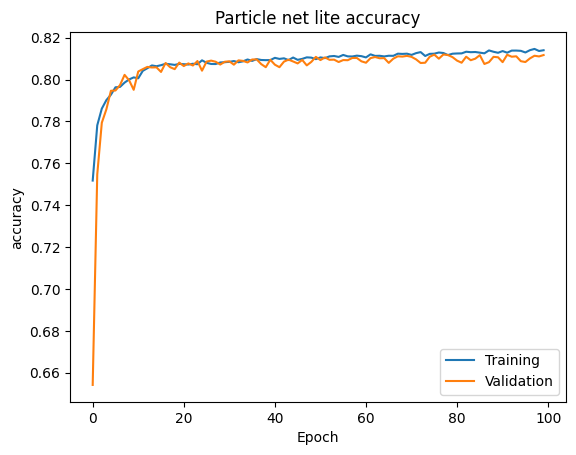

In [21]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Particle net lite accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

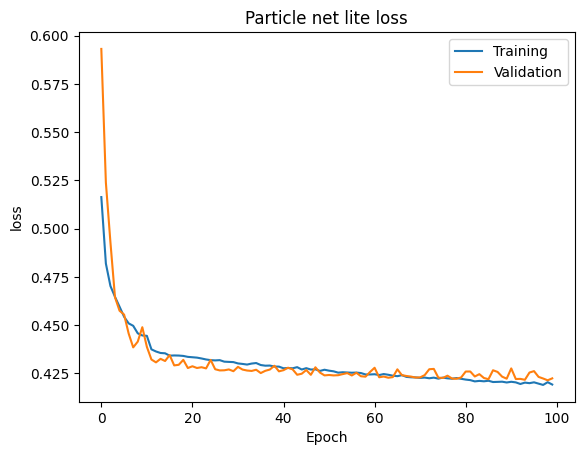

In [22]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Particle net lite loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
res = model.evaluate(test_dataset, y_test)

469/469 [==============================] - 16s 32ms/step - loss: 0.5118 - accuracy: 0.7557


In [25]:
print("test loss, test acc:", res)

test loss, test acc: [0.511802077293396, 0.7557333111763]
